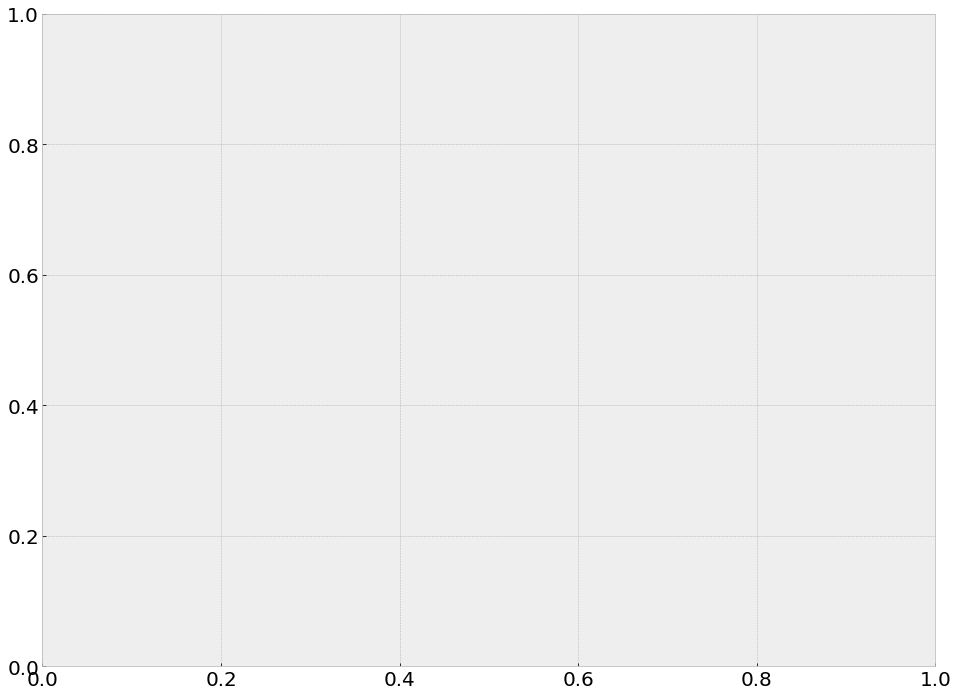

In [1]:
from cwgan_base import *
import math
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from scipy.stats import multivariate_normal, beta
import matplotlib._pylab_helpers

plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)

from itertools import product
from tqdm import tqdm

In [2]:
# Decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
#true g
def g(x):
    g=np.zeros((x.shape[0], 10))
    g[:,0] = np.sin(x[:,0])
    g[:,1] = np.sin(x[:,1])
    g[:,2] = np.sin(x[:,2])
    g[:,3] = np.exp(x[:,0])
    g[:,4] = 2*np.sqrt(np.abs(x[:,1]))
    g[:,5] = np.cos(2*math.pi*x[:,0]*x[:,1]*x[:,2])
    g[:,6] = x[:,0]*x[:,1]*x[:,2]
    g[:,7] = np.sqrt(np.abs(np.sum(x, axis=1)))
    g[:,8] = np.sum(x,axis=1)
    g[:,9] = np.linalg.norm(x, axis = 1)
    return(g)

In [4]:
def h(z):
    h= np.zeros((z.shape[0],3))
    h[:,0] = z[:,0] + z[:,1]**2 + z[:,2]**3
    h[:,1] = z[:,3] * z[:,4] + z[:,5] * z[:,6]
    h[:,2] = np.sin(z[:,7]) - z[:,8] * np.sqrt(np.abs(z[:,9]))
    return(h)

In [5]:
def generate_data(y=None, num=1000):
    z = torch.rand((num, 7), device = device)
    if y is None:
        ys = torch.rand((num, 3), device = device)
    else:
        ys = y.repeat(num, 1)
    yz = torch.cat( (z,ys), 1)
    data = g(h(yz.cpu().detach().numpy()))
    return(data, ys)
    

def get_coverage(trainer, y, num = 1000, runs = 5):
    covs= []
    ys = y.repeat(num,1)
    for i in range(runs):
        # only X1+X2+...+X10
        gens = np.sum(trainer.generate_images(ys, num_outputs = num).detach().cpu().numpy(), 1)
        reals = np.sum(generate_data(y, num=num)[0], 1)
        
        gens = np.sort(gens)
        lower = gens[int(np.ceil(0.5*alpha*num))]
        upper = gens[int(np.ceil((1-0.5*alpha)*num))]
        covs.append( sum([lower<=reals[i]<= upper for i in range(num)])/num )
    #return mean coverage, std coverage
    return(np.mean(covs), np.std(covs))
    
def compute_ot(trainer, y, num = 1000, runs = 5):
    ots = []
    ys = y.repeat(num, 1)
    for i in range(runs):
        gens = trainer.generate_images(ys, num_outputs=num).detach().cpu().numpy()
        reals = generate_data(y, num=num)[0]
        gens2 = np.concatenate((gens,ys),axis=1)
        reals2 = np.concatenate((reals,ys),axis=1)
        ots.append(get_ot(gens2,reals2))
    return(np.mean(ots), np.std(ots))

In [6]:
z_dim=7
y_dim = 3
x_dim = 10
ddim= 128
gdim = 32
n_batches = 100
# number of ot and cov estims
num_otruns = 1
# number of equal models trained
model_runs = 5 #5
alpha = 0.05

y_base = torch.tensor([0.5,0.5,0.5]).view((1,3))

bs = 64

#train to test ratio
tt = 0.5
#n batches
N = [1, 5, 15, 50, 150] #[3, 15, 150, 750]

# continue training for EP epochs 
EP = [100,200,400]
models=[]
trainers=[]
COV=np.zeros((len(N),len(EP), 2))
OT=np.zeros((len(N),len(EP), 2))



# gen and discr architectures for each n in N
PG = []
PD = []


gdim = 32
ddim = 128

for _ in range(len(N)):
    PG.append( (z_dim+y_dim,gdim,gdim,gdim, x_dim) )
    PD.append( (x_dim+y_dim, ddim, ddim, ddim, ddim, ddim, 1) )

/kaggle/usr/lib/cwgan_base/cwgan_base.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_yset = to_cuda(torch.tensor(y[:int(np.ceil(train_size))]).float())
/kaggle/usr/lib/cwgan_base/cwgan_base.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_yset = to_cuda(torch.tensor(y[int(np.ceil(train_size)):]).float())
  0%|          | 0/100 [00:00<?, ?it/s]

N= 1


100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
/kaggle/usr/lib/cwgan_base/cwgan_base.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_yset = to_cuda(torch.tensor(y[:int(np.ceil(train_size))]).float())
/kaggle/usr/lib/cwgan_base/cwgan_base.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_yset = to_cuda(torch.tensor(y[int(np.ceil(train_size)):]).float())
  0%|          | 0/100 [00:00<?, ?it/s]

N= 5


100%|██████████| 400/400 [00:54<00:00,  7.30it/s]
/kaggle/usr/lib/cwgan_base/cwgan_base.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_yset = to_cuda(torch.tensor(y[:int(np.ceil(train_size))]).float())
/kaggle/usr/lib/cwgan_base/cwgan_base.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_yset = to_cuda(torch.tensor(y[int(np.ceil(train_size)):]).float())
  0%|          | 0/100 [00:00<?, ?it/s]

N= 15


100%|██████████| 400/400 [02:02<00:00,  3.26it/s]
/kaggle/usr/lib/cwgan_base/cwgan_base.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_yset = to_cuda(torch.tensor(y[:int(np.ceil(train_size))]).float())
/kaggle/usr/lib/cwgan_base/cwgan_base.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_yset = to_cuda(torch.tensor(y[int(np.ceil(train_size)):]).float())
  0%|          | 0/100 [00:00<?, ?it/s]

N= 50


100%|██████████| 400/400 [04:53<00:00,  1.36it/s]
/kaggle/usr/lib/cwgan_base/cwgan_base.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_yset = to_cuda(torch.tensor(y[:int(np.ceil(train_size))]).float())
/kaggle/usr/lib/cwgan_base/cwgan_base.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_yset = to_cuda(torch.tensor(y[int(np.ceil(train_size)):]).float())
  0%|          | 0/100 [00:00<?, ?it/s]

N= 150


100%|██████████| 400/400 [14:44<00:00,  2.21s/it]


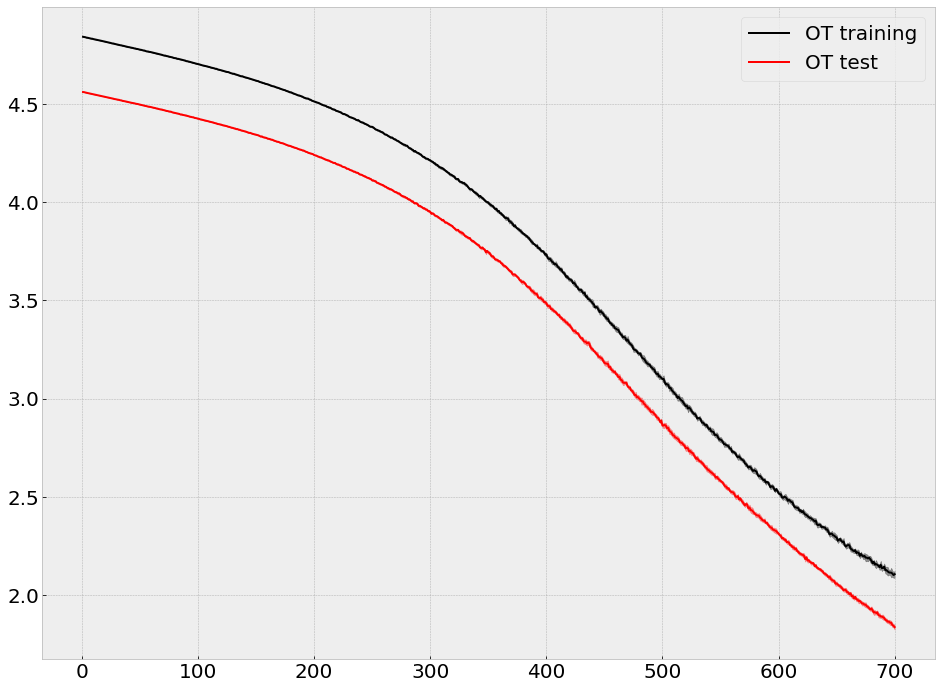

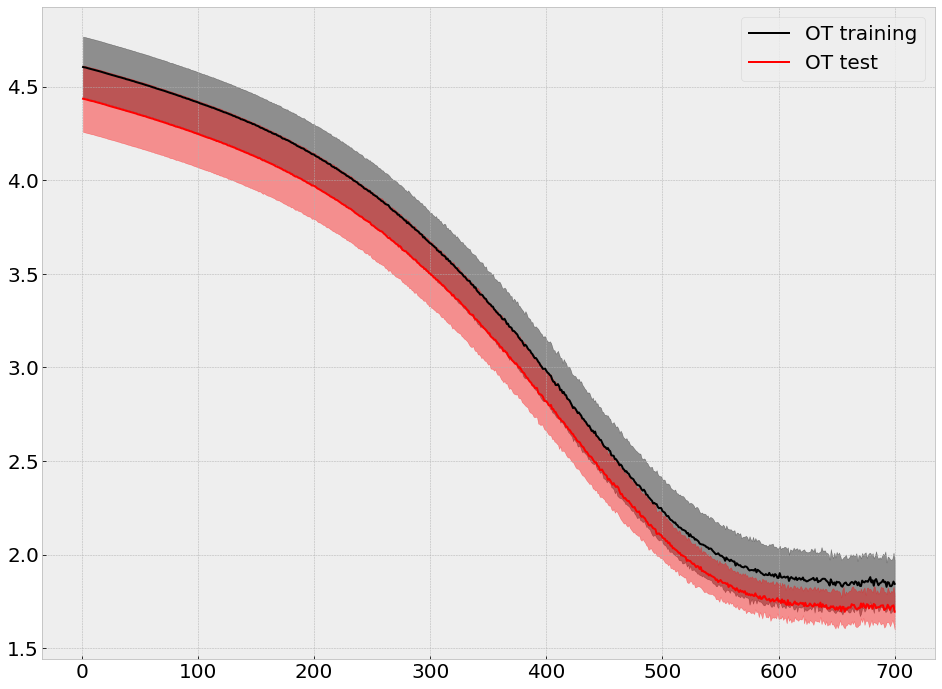

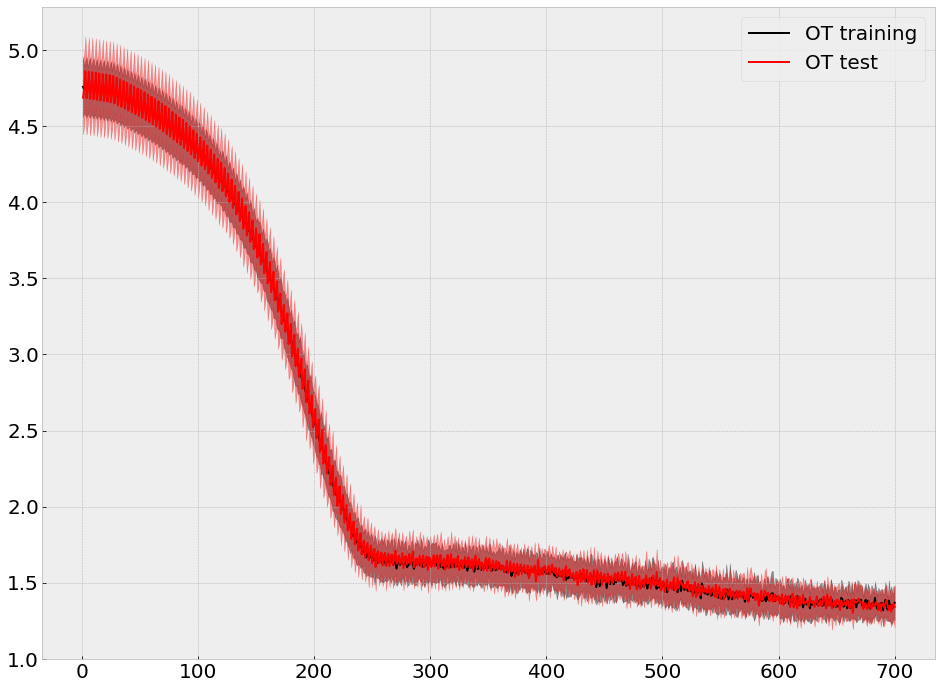

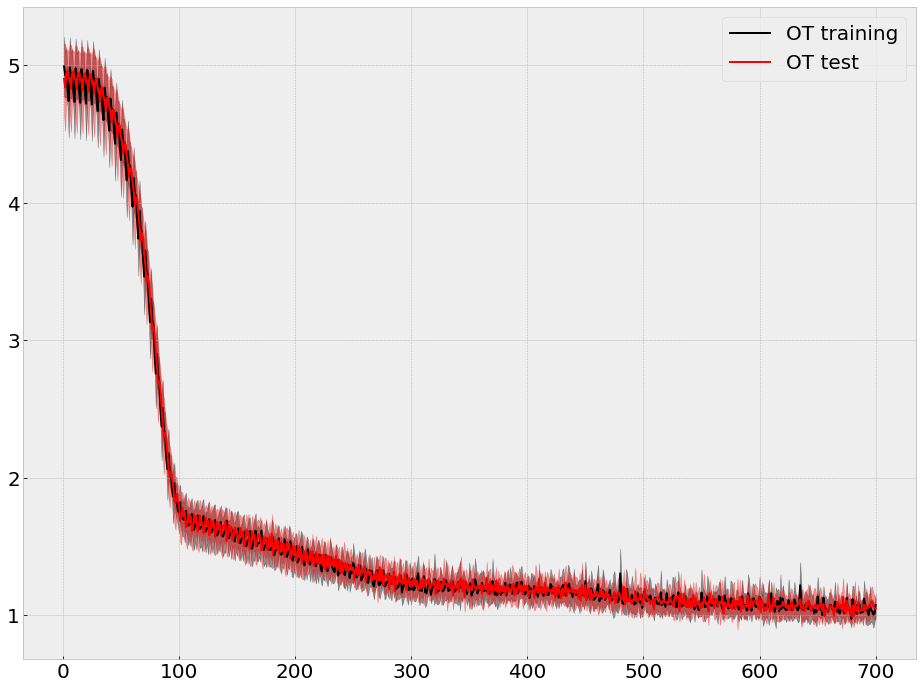

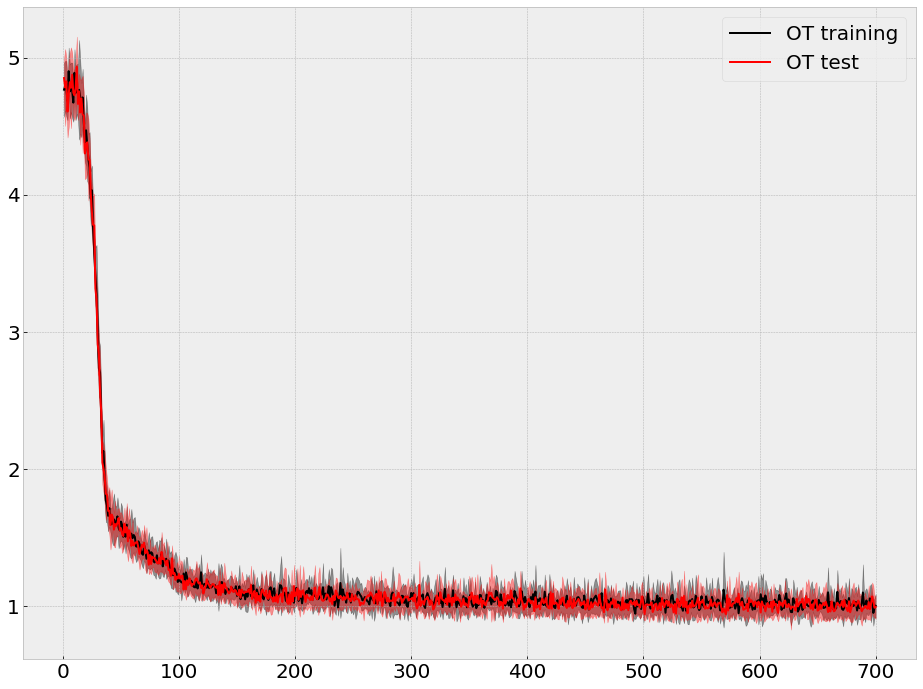

In [7]:
random.seed(1057)
torch.manual_seed(1057)

for i in range(len(N)):
    print('N=',N[i])
    n_batches = N[i]

    pg = PG[i]
    pd = PD[i]

    cs = np.zeros((len(EP),model_runs))
    os = np.zeros((len(EP),model_runs))
    
    for r in range(model_runs):
        x,y = generate_data(num=bs*n_batches*2)
        trains, tests = get_cdataloader(x, y, tt_split = tt, shuffle = False)
        #trains = get_dataloader(data, nosplit = True)
        models.append( cWGAN(pg, pd) )
        trainers.append( cWGANTrainer(model=models[-1], trains=trains, testset = tests, gantype = 'wgangp', noise = 'unif') )

        # train D and G with estimates after each epoch, use num_batches for estimates
        #train for 100, 200, 400, 400
        for i_ep in range(len(EP)):
            trainers[-1].train_estim(num_epochs=EP[i_ep], penalty = 0.1, G_lr=1e-4, D_lr=1e-4, G_wd = 0.01, D_steps_standard=5, num_batches = 1, num_estims = 10, onlypot = True)
            cs[i_ep,r] = get_coverage(trainers[-1], y = y_base, num = 1000, runs = num_otruns)[0] #[0] for num_otruns = 1
            os[i_ep,r] = compute_ot(trainers[-1], y = y_base, num = 1000, runs = num_otruns)[0]
        
        
    for i_ep in range(len(EP)):
        COV[i, i_ep, :] = np.mean(cs[i_ep,:]), np.std(cs[i_ep,:])
        OT[i, i_ep, :] = np.mean(os[i_ep,:]), np.std(os[i_ep,:])
    
    
    yss = np.array(trainers[-1].W1s)
    upper = len(yss) #500
    xs = np.linspace(1,upper,upper)
    y2 = np.array(trainers[-1].W1test)

    plt.figure(i)
    plt.rcParams["figure.figsize"] = (8*2,6*2)
    plt.style.use('bmh')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize = 20)
    plt.plot(xs, yss[:,0], '-', color='black', label = 'OT training')
    plt.fill_between(xs, yss[:,0] - yss[:,1], yss[:,0] + yss[:,1],
                     color='black', alpha=0.4)
    plt.plot(xs, y2[:,0], '-', color='red', label = 'OT test')
    plt.fill_between(xs, y2[:,0] - y2[:,1], y2[:,0] + y2[:,1],
                     color='red', alpha=0.4)
    plt.legend(fontsize = 20)
    #plt.ylim(-0.5,1.5)
    plt.savefig('to10_%d.png'%i,dpi=150)    

In [8]:
COV

array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.5482    , 0.02611053]],

       [[0.        , 0.        ],
        [0.0012    , 0.00193907],
        [0.549     , 0.02853069]],

       [[0.        , 0.        ],
        [0.5932    , 0.08125368],
        [0.9006    , 0.08100519]],

       [[0.5612    , 0.02517459],
        [0.87      , 0.02055237],
        [0.9262    , 0.0143861 ]],

       [[0.9086    , 0.01121784],
        [0.9376    , 0.00915642],
        [0.9444    , 0.01246756]]])

In [9]:
OT

array([[[4.59485858, 0.13159958],
        [3.98586949, 0.25236124],
        [1.66920035, 0.16531822]],

       [[4.47018489, 0.09417684],
        [3.68563896, 0.18022661],
        [1.50148717, 0.1091492 ]],

       [[4.26039907, 0.19828913],
        [1.72042906, 0.43924285],
        [1.10362134, 0.11024718]],

       [[1.58199338, 0.07032525],
        [0.72561318, 0.03782103],
        [0.5248394 , 0.04015775]],

       [[0.74528041, 0.00979675],
        [0.47055157, 0.02068958],
        [0.31386102, 0.02944837]]])

In [10]:
for i in range(len(models)):
    torch.save(models[i] , 'model_%d.pt'%i)

In [11]:
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)

In [12]:
pl.figure(0)

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

test_idx = int(np.ceil(0.8*bs*n_batches))

train_gens = trainer.generate_images(num_outputs=test_idx).detach().numpy()
trains = data[:test_idx,:]
test_gens = trainer.generate_images(num_outputs=bs*n_batches-test_idx).detach().numpy()
tests = data[test_idx:,:]

W1_train = get_ot(trains, train_gens)
W1_test = get_ot(tests, test_gens)
W1_train,W1_test

figures=[manager.canvas.figure for manager in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
print(figures)

# [<matplotlib.figure.Figure object at 0xb788ac6c>, <matplotlib.figure.Figure object at 0xa143d0c>]

for i, figure in enumerate(figures):
    figure.savefig('figure%d.png' % i)

test_idx = int(np.ceil(0.8*bs*n_batches))

train_gens = trainer.generate_images(num_outputs=test_idx).detach().numpy()
trains = data[:test_idx,:]
test_gens = trainer.generate_images(num_outputs=bs*n_batches-test_idx).detach().numpy()
tests = data[test_idx:,:]

W1_train = get_ot(trains, train_gens)
W1_test = get_ot(tests, test_gens)
W1_train,W1_test